# Mass conservation and Interface sharpness in VOF method

## Auxiliary code

In [1]:
include("../src/WaterLily.jl")
using .WaterLily
using Plots
using Plots.PlotMeasures
using Printf
using ProgressMeter
using LaTeXStrings

In [2]:
default()
Plots.scalefontsizes()
default(fontfamily="Palatino",linewidth=1.5, framestyle=:axes, label=nothing, grid=false, tick_dir=:out, size=(550,480),right_margin=5mm,left_margin=5mm,top_margin=5mm,bottom_margin=5mm,markerstrokewidth=0,markersize=8)
Plots.scalefontsizes(1.5)

In [3]:
Threads.nthreads()

4

In [4]:
uv(i,x,t,T) = i==1 ? u(x[1],x[2],t,T) : v(x[1],x[2],t,T)
u(x,y,t,T) = sin(π*x)^2*sin(2π*y)*cos(π*t/T)
v(x,y,t,T) = -sin(2π*x)*sin(π*y)^2*cos(π*t/T);

In [5]:
function generateCoord(scalarArray::AbstractArray{T,D};normalize=1,shift=zeros(T,D)) where {T,D}
    Ng = size(scalarArray)
    N = Ng.-2
    cenTuple = ntuple((i) -> ((1:Ng[i]) .- 1.5 .- N[i]/2 .- shift[i])/normalize,D)
    edgTuple = ntuple((i) -> ((1:Ng[i]) .- 2.0 .- N[i]/2 .- shift[i])/normalize,D)
    limTuple = ntuple((i) -> ([0,N[i]] .- N[i]/2 .- shift[i])/normalize,D)

    return cenTuple,edgTuple,limTuple
end
function plotContourf!(plt,xc,yc,f;clim=(-5,5),levels=60,color=:seismic,lw=0)
    clamp!(f,clim...)
    Plots.contourf!(plt,xc,yc,f',clim=clim,levels=levels,color=color,lw=lw)
    return plt
end
function plotContour!(plt,xc,yc,f;clim=(0,1),levels=[0.5],color=:Black,lw=1.5)
    clamp!(f,clim...)
    Plots.contour!(plt,xc,yc,f',levels=levels,color=color,lw=lw,clim=clim)
    return plt
end

function plotHeatmap!(plt,xc,yc,f;clim=(-5,5),levels=60,color=:seismic,lw=0)
    clamp!(f,clim...)
    Plots.heatmap!(plt,xc,yc,f',clim=clim,levels=levels,color=color,lw=lw)
    return plt
end

function organizePlot!(plt,xlim,ylim)
    Plots.plot!(plt,xlimit=xlim,ylimit=ylim,aspect_ratio=:equal)
end

organizePlot! (generic function with 1 method)

In [6]:
function main(;N=32,CFL=0.25,method="gVOF",conservation=true,split=true)
    cID = @sprintf("VortexDeforminggVOF2DN%d", N)
    NN = (N,N)
    Ng = NN.+2
    Nd = (Ng...,2)

    δt = CFL
    T = 4N
    tArray = 0:δt:T

    vel = zeros(Nd)
    nor = zeros(Nd)
    alp = zeros(Ng)

    InterfaceSDF(x) = √sum((x.-[0.50,0.75]*N).^2) - 0.15N

    c = cVOF(NN; InterfaceSDF)

    cenTuple,edgTuple,limTuple = generateCoord(c.f;normalize=N)

    fList = []
    divList = []

    method=="gVOF" && (vofmethod! = WaterLily.updateVOF!)
    method=="aVOF" && (vofmethod! = WaterLily.aVOF!)

    anim = Plots.Animation()
    @showprogress for tᵢ ∈ tArray
        push!(fList,sum(c.f[WaterLily.inside(c.f)]))
        WaterLily.apply!((i,x)->uv(i,x/N,tᵢ,T),vel)
        vofmethod!(δt,c.f,c.fᶠ,c.n̂,c.α,vel,vel,c.c̄;dilation=conservation,split=true)
        plt = Plots.plot()
        plt = plotContour!(plt, cenTuple[1], cenTuple[2],c.f,clim=(0,1),color=:isoluminant_cgo_70_c39_n256,levels=[0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.8])
        Plots.plot!(plt,cbar_title=L"f",xlabel=L"x",ylabel=L"y")
        organizePlot!(plt,limTuple[1],limTuple[2])
        frame(anim,plt)
        flush(stdout)
    end
    # Plots.gif(anim,cID*"_VOF.gif",fps=50)
    # Plots.plot(tArray,(fList.-fList[1])./fList[1])
    # Plots.savefig(cID*"_MassLoss.png")
    return tArray/N, anim, fList, divList
end

main (generic function with 1 method)

## Hands-on!

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
┌ Info: Saved animation to /var/folders/rm/jb3vm3c5061g59ks51w_tsr80000gn/T/jl_DaFGXID012.gif
└ @ Plots /Users/tzuyaohuang/.julia/packages/Plots/a3u1v/src/animation.jl:156


Plots.AnimatedGif("/var/folders/rm/jb3vm3c5061g59ks51w_tsr80000gn/T/jl_DaFGXID012.gif")
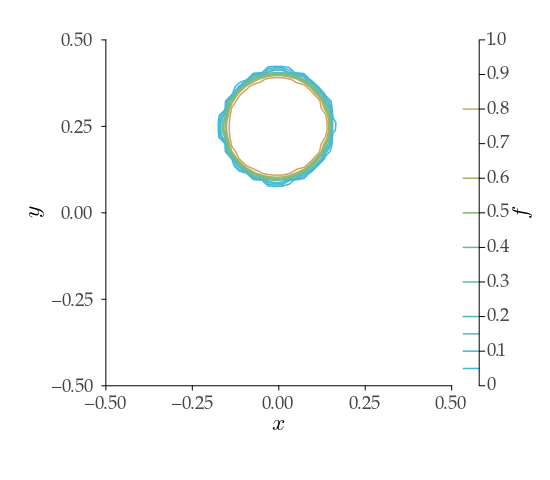

In [10]:
tArray,anim,fList,dList = main(;N=48,CFL=0.25,method="gVOF",conservation=true,split=true);
gif(anim,fps=length(tArray)÷15)

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tzuyaohuang/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tzuyaohuang/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tzuyaohuang/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tzuyaohuang/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tzuyaohuang/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tzuyaohuang/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tzuyaohuang/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


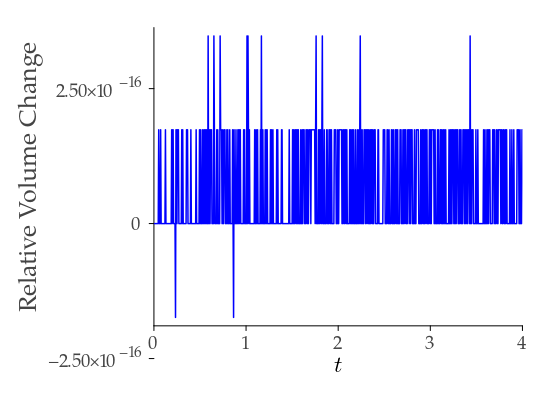

In [9]:
Plots.plot(tArray,(fList.-fList[1])/fList[1],color=:blue)
Plots.plot!(ylabel="Relative Volume Change",xlabel=L"t",xlimit=(0,4))
Plots.plot!(size=(550,400))